In [1]:
from activation_additions import prompt_utils, hook_utils, hyperparameter_search
import numpy as np
from contextlib import contextmanager
from typing import Tuple, Callable, Optional

import numpy as np
import torch as t
from torch import nn
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
import accelerate
import importlib
import torch.nn.functional as F
from typing import List

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "gpt2-medium"  # you can replace 'gpt2-medium' with 'gpt2' if you want the smaller model

# Load model
model = GPT2LMHeadModel.from_pretrained(model_name).to("cuda")

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'

In [3]:
def process_with_avg_prob_embedding(model, logits, attention_mask=None):
    # Ensure model is in evaluation mode
    model.eval()

    device = model.device  # This line captures the device model is on

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits.to(device), dim=-1)  # Ensure logits are on the same device

    # Get all possible embeddings from the model
    all_embeddings = model.transformer.wte.weight

    weighted_embeddings = torch.matmul(probabilities, all_embeddings)
    weighted_embeddings = weighted_embeddings.unsqueeze(0)

    hidden_states = weighted_embeddings

    # Pass the repeated averaged embeddings through the model layers
    for block in model.transformer.h:  # Updated loop to iterate through GPT2 blocks
        hidden_states = block(hidden_states)[0]  # Taking the first output as the transformed hidden state

    # Convert the final hidden states back to logits
    logits_output = model.transformer.ln_f(hidden_states)  # Apply final layer norm
    logits_output = model.transformer.wte.weight.matmul(logits_output.transpose(1, 2)).transpose(1, 2)  # Convert back to logits

    # Return the logits
    return logits_output.squeeze(0)  # Removing the batch dimension

In [129]:
def create_logit_tensor_from_prompt(prompt: str, tokenizer):
    """
    Given a prompt, tokenizes the prompt using the provided tokenizer and returns a logit tensor 
    where positions corresponding to the tokens have a value of 0 and all other positions have a value of -inf.
    """
    
    # Tokenize the prompt
    tokenized_output = tokenizer.encode(prompt, return_tensors="pt").squeeze()
    
    # Check if tokenized_output is a scalar
    if len(tokenized_output.shape) == 0:
        tokenized_output = tokenized_output.unsqueeze(0)  # Convert scalar to 1D tensor
    
    tokenized_output = tokenized_output.tolist()
    
    vocab_size = tokenizer.vocab_size
    tensor = t.full((len(tokenized_output), vocab_size), float('-inf'))
    
    for idx, token in enumerate(tokenized_output):
        tensor[idx, token] = 0.0
        
    return tensor


In [5]:

def kl_divergence_from_logits(logits1, logits2):
    """
    Computes the KL divergence between two distributions represented by logits.
    
    Args:
    - logits1 (list or torch.Tensor): Logits for the first distribution.
    - logits2 (list or torch.Tensor): Logits for the second distribution.
    
    Returns:
    - KL divergence (torch.Tensor): KL(logits1 || logits2)
    """

    # Convert lists to tensors
    logits1 = torch.tensor(logits1)
    logits2 = torch.tensor(logits2)

    # Convert logits to probabilities
    probs1 = F.softmax(logits1, dim=-1)
    probs2 = F.softmax(logits2, dim=-1)

    # Compute KL divergence
    kl_div = F.kl_div(probs1, probs2, reduction='batchmean')

    return kl_div

In [83]:
def generate_strings(N, M, model, tokenizer):
    """
    Generate N strings each with M tokens using GPT-2.

    Args:
    - N (int): Number of strings to generate.
    - M (int): Number of tokens per string.
    - model (GPT2LMHeadModel): Pre-trained GPT-2 model.
    - tokenizer (GPT2Tokenizer): Tokenizer for GPT-2.

    Returns:
    - List of N strings.
    """

    generated_strings = []
    
    # Set model in evaluation mode
    model.eval()

    # If bos_token is not available in the tokenizer, use a random token (e.g., "a")
    input_token = tokenizer.bos_token or "a"
    input_ids = tokenizer.encode(input_token, return_tensors="pt").to("cuda")

    while len(generated_strings)!=N:
        with torch.no_grad():  # Disable gradient calculations
            output = model.generate(input_ids, max_length=M+1, do_sample=True, pad_token_id=tokenizer.eos_token_id, num_return_sequences=1)
        
        # Convert the generated tokens to a string
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        if len(tokenizer.encode(generated_text)) == M:
            generated_strings.append(generated_text)
    

    return generated_strings

In [122]:
def run_experiments(model, tokenizer,Number_of_completions,Length_of_completions,N_samples):
    kl_divs_linearity=t.zeros((Number_of_completions,Length_of_completions,N_samples))
    avg_kl_divs=t.zeros((Number_of_completions,Length_of_completions,N_samples))
    std_kl_divs=t.zeros((Number_of_completions,Length_of_completions,N_samples))
    for N in range(Number_of_completions):
        for M in range(Length_of_completions):
            for O in range(N_samples):
                strings = generate_strings(N+1, M+1, model, tokenizer)
                logits=[create_logit_tensor_from_prompt(s,tokenizer) for s in strings]
                average_input_logits = torch.log(torch.mean(torch.stack([torch.nn.functional.softmax(logit, dim=-1) for logit in logits]), dim=0))

                output_logits=[process_with_avg_prob_embedding(model, l) for l in logits]
                output_logits_averagred_before_forwardpass=process_with_avg_prob_embedding(model, average_input_logits)
                output_logits_averagred_after_forwardpass=torch.stack(output_logits).mean(dim=0)

                kl_between_members=[]
                for i in range(len(output_logits)):
                    for j in range(len(output_logits)):
                        if i!=j:
                            div=kl_divergence_from_logits(output_logits[i][-1], output_logits[j][-1])
                            kl_between_members.append(float(div.item()))
                kl_on_linearity=kl_divergence_from_logits(output_logits_averagred_before_forwardpass[-1], output_logits_averagred_after_forwardpass[-1]).item()
                
                kl_divs_linearity[N,M,O]=kl_on_linearity
                avg_kl_divs[N,M,O]=np.mean(kl_between_members)
                std_kl_divs[N,M,O]=np.std(kl_between_members)
    return kl_divs_linearity,avg_kl_divs,std_kl_divs

In [132]:
kl_divs_linearity,avg_kl_divs,std_kl_divs=run_experiments(model, tokenizer,5,5,5)


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


/tmp/ipykernel_1693488/4215707364.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits1 = torch.tensor(logits1)
/tmp/ipykernel_1693488/4215707364.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits2 = torch.tensor(logits2)
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, pleas

In [133]:
nonlinarity=t.mean(kl_divs_linearity,dim=2)
avg_normal=t.mean(avg_kl_divs,dim=2)
result_tensor = nonlinarity / avg_normal


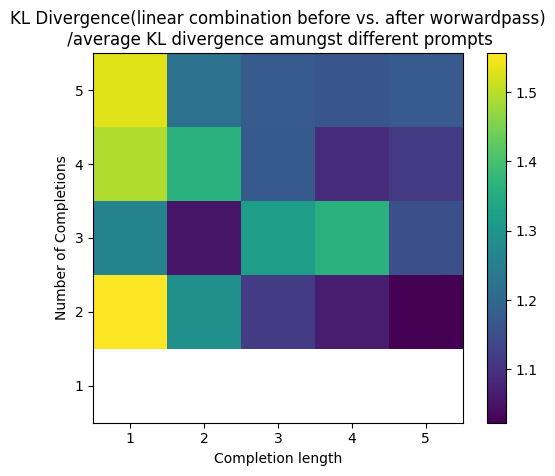

In [143]:
import matplotlib.pyplot as plt

plt.imshow(result_tensor, origin='lower')
plt.colorbar()  # Add a colorbar

# Add axis descriptions
plt.ylabel('Number of Completions')
plt.xlabel('Completion length')
plt.title('KL Divergence(linear combination before vs. after worwardpass)\n /average KL divergence amungst different prompts')

# Adjust the ticks
plt.xticks(range(result_tensor.shape[1]), [str(i+1) for i in range(result_tensor.shape[1])])
plt.yticks(range(result_tensor.shape[0]), [str(i+1) for i in range(result_tensor.shape[0])])
#y_ticks = plt.yticks()[0]  # Get current ticks
#plt.yticks(y_ticks, y_ticks + 1)  # Adjust ticks to start from 1

plt.show()


In [128]:
strings

['To', 'This', 'You', 'If', 'For', 'The', 'So', 'A', 'He', 'My']

In [130]:
# Example usage:
N = 10
M = 1
strings = generate_strings(N, M, model, tokenizer)
logits=[create_logit_tensor_from_prompt(s,tokenizer) for s in strings]
average_input_logits = torch.log(torch.mean(torch.stack([torch.nn.functional.softmax(logit, dim=-1) for logit in logits]), dim=0))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [125]:
output_logits=[process_with_avg_prob_embedding(model, l) for l in logits]
output_logits_averagred_before_forwardpass=process_with_avg_prob_embedding(model, average_input_logits)
output_logits_averagred_after_forwardpass=torch.stack(output_logits).mean(dim=0)


In [126]:
kl_between_members=[]
for i in range(len(output_logits)):
    for j in range(len(output_logits)):
        if i!=j:
            div=kl_divergence_from_logits(output_logits[i][-1], output_logits[j][-1])

            kl_between_members.append(float(div.item()))
kl_on_linearity=kl_divergence_from_logits(output_logits_averagred_before_forwardpass[-1], output_logits_averagred_after_forwardpass[-1]).item()

/tmp/ipykernel_1693488/4215707364.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits1 = torch.tensor(logits1)
/tmp/ipykernel_1693488/4215707364.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits2 = torch.tensor(logits2)


In [82]:
kl_on_linearity/np.mean(kl_between_members)

1.1311870861750077